## **IMPORTS**  
<hr style="border: none; height: 3px; background: #e10600;">

**— Environment Setup & Dependencies**


In [ ]:
import os
# Force pure python implementation
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

# --- CONFIGURATION (THE ROBUST WAY) ---
# This gets the folder where your notebook is actually saved
CURRENT_DIR = os.getcwd()

# We check if we are already inside 'PENCIL VS PEN' or if it's a subfolder
if os.path.basename(CURRENT_DIR) == "PENCIL VS PEN":
    DATA_BASE = os.path.join(CURRENT_DIR, "split_dataset")
else:
    DATA_BASE = os.path.join(CURRENT_DIR, "PENCIL VS PEN", "split_dataset")

TRAIN_DIR = os.path.join(DATA_BASE, "train")
TEST_DIR = os.path.join(DATA_BASE, "test")

# --- VERIFICATION PRINT ---
print(f"Checking: {TRAIN_DIR}")
if os.path.exists(TRAIN_DIR):
    print("✅ SUCCESS: Found the folder!")
    print(f"Contents: {os.listdir(TRAIN_DIR)}")
else:
    print("❌ ERROR: Path still not found. Please run 'os.listdir()' in a new cell and show me.")

# --- REQUIREMENTS ---
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
EPOCHS = 20

Checking: c:\Users\evang\Downloads\Pen_vs_Pencil_Project\PENCIL VS PEN\split_dataset\train
✅ SUCCESS: Found the folder!
Contents: ['pen', 'pencil']


## **PHASE 1**  
<hr style="border: none; height: 3px; background: #e10600;">

**— Prepare Data**

In [20]:
# --- DATA GENERATORS ---

# 1. TRAIN GENERATOR (Hard Mode)
# Augmentation helps the model learn to recognize pens/pencils from different angles
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

print("Loading Training Data...")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=42
)

# 2. VALIDATION GENERATOR (Easy Mode)
# We don't augment validation data; we want to test on clean images.
test_datagen = ImageDataGenerator(rescale=1./255)

print("Loading Validation Data...")
validation_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    seed=42
)

# --- QUICK VERIFICATION ---
if train_generator.samples > 0:
    print(f"✅ Success! Found {train_generator.samples} training images.")
    print(f"Classes found: {train_generator.class_indices}")
else:
    print("❌ Error: Found 0 images. Check if your images are inside subfolders like 'train/pen' and 'train/pencil'.")

Loading Training Data...
Found 320 images belonging to 2 classes.
Loading Validation Data...
Found 80 images belonging to 2 classes.
✅ Success! Found 320 training images.
Classes found: {'pen': 0, 'pencil': 1}


## **PHASE 2**  
<hr style="border: none; height: 3px; background: #e10600;">

**— Build CNN Model**

In [24]:
model = tf.keras.models.Sequential([
    # Block 1
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Block 2
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Block 3
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    # tf.keras.layers.MaxPooling2D(2, 2),


    # The Brain
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    
    # CRITICAL: This layer forces the lines to stick together
    tf.keras.layers.Dropout(0.3), 

    tf.keras.layers.Dense(1, activation='sigmoid')
])

## **PHASE 3**  
<hr style="border: none; height: 3px; background: #e10600;">

**— Compile and Train**

In [25]:
# Requirement: Adam, Binary Crossentropy, Accuracy
model.compile(
    # We use 0.0005 (Standard Adam is usually 0.001). 
    # This slightly slower speed creates SMOOTHER graphs.
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

print(f"\nStarting Training ({EPOCHS} Epochs)...")

checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_accuracy', save_best_only=True, verbose=1)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS, # Requirement: 10-15 Epochs
    callbacks=[checkpoint]
)


Starting Training (25 Epochs)...
Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 1.3268 - accuracy: 0.4719
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to c:\Users\evang\Downloads\Pen_vs_Pencil_Project\PENCIL VS PEN\final_model.h5
10/10 [==============================] - 10s 1s/step - loss: 1.3268 - accuracy: 0.4719 - val_loss: 0.6991 - val_accuracy: 0.5000
Epoch 2/25
10/10 [==============================] - ETA: 0s - loss: 0.6561 - accuracy: 0.6156
Epoch 2: val_accuracy improved from 0.50000 to 0.73750, saving model to c:\Users\evang\Downloads\Pen_vs_Pencil_Project\PENCIL VS PEN\final_model.h5
10/10 [==============================] - 17s 2s/step - loss: 0.6561 - accuracy: 0.6156 - val_loss: 0.5491 - val_accuracy: 0.7375
Epoch 3/25
10/10 [==============================] - ETA: 0s - loss: 0.6145 - accuracy: 0.6250
Epoch 3: val_accuracy did not improve from 0.73750
10/10 [==============================] - 14s 1s/step - loss: 0.6145 - accuracy: 0.

## **PHASE 4**  
<hr style="border: none; height: 3px; background: #e10600;">

**— Graph Results**

Graph saved to c:\Users\evang\Downloads\Pen_vs_Pencil_Project\PENCIL VS PEN\accuracy_graph.png


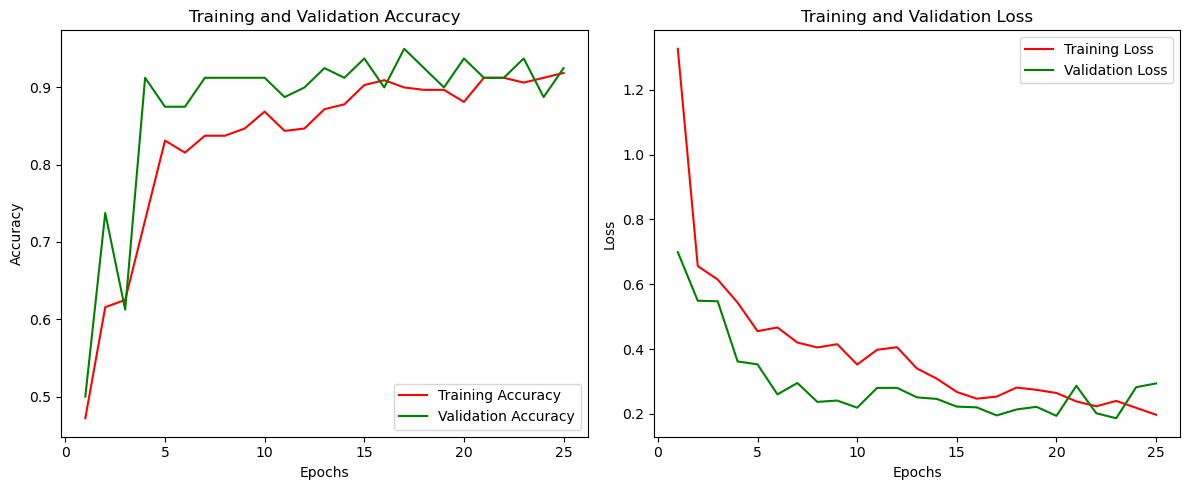

In [27]:
import matplotlib.pyplot as plt

# Get metrics
acc = history.history.get('accuracy', [])
val_acc = history.history.get('val_accuracy', [])
loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss', [])
epochs_range = range(1, len(acc)+1)

# Create figure
plt.figure(figsize=(12, 5))

# --- Accuracy subplot ---
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='red')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# --- Loss subplot ---
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Save and show
plt.tight_layout()
plt.savefig(GRAPH_SAVE_PATH)
print(f"Graph saved to {GRAPH_SAVE_PATH}")
plt.show()

## **TEST MODEL INDIVIDUALLY**
<hr style="border: none; height: 3px; background: #e10600;">

1/1 [==============================] - 0s 83ms/step
------------------------------
PREDICTION: PENCIL
CONFIDENCE: 94.07%
------------------------------


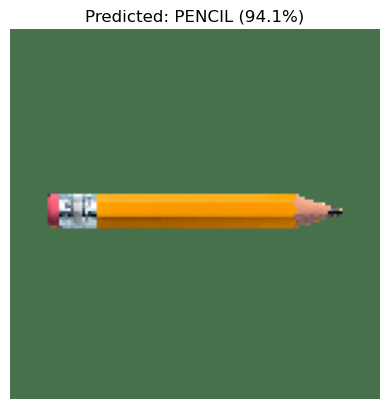

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Your specific image path
test_image_path = r"C:\Users\evang\Downloads\a-classic-yellow-number-two-pencil-sharpened-and-ready-for-writing-displayed-horizontally-png.png"
try:
    # Load image (128x128 as per PDF requirements)
    img = load_img(test_image_path, target_size=(128, 128))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0 # Normalize 0-1

    # Predict
    prediction = model.predict(img_array)
    score = prediction[0][0] # Get the single probability value

    # Identify Class Names (0 vs 1)
    class_indices = {v: k for k, v in train_generator.class_indices.items()}
    
    # Binary Classification Logic (Sigmoid)
    # < 0.5 = Class 0
    # > 0.5 = Class 1
    print("-" * 30)
    if score < 0.5:
        class_name = class_indices[0].upper()
        confidence = (1 - score) * 100
    else:
        class_name = class_indices[1].upper()
        confidence = score * 100

    print(f"PREDICTION: {class_name}")
    print(f"CONFIDENCE: {confidence:.2f}%")
    print("-" * 30)

    # Display
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {class_name} ({confidence:.1f}%)")
    plt.show()

except Exception as e:
    print(f"Error: {e}")